In [9]:
import re
import math
import numpy as np
import pandas as pd
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Phần 1

In [1]:
# 1. Hàm tiền xử lý văn bản
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()

    return words

# 2. Hàm tính TF (Term Frequency)
def calculate_tf(document):
    words = preprocess_text(document)
    word_counts = Counter(words)
    total_words = len(words)
    tf_dict = {word: count/total_words for word, count in word_counts.items()}

    return tf_dict

# 3. Hàm tính IDF (Inverse Document Frequency)
def calculate_idf(documents):
    idf_dict = {}
    N = len(documents)
    word_in_docs = {}
    for doc in documents:
        words = set(preprocess_text(doc))  
        for word in words:
            word_in_docs[word] = word_in_docs.get(word, 0) + 1
    
    # Tính IDF cho mỗi từ
    for word, doc_freq in word_in_docs.items():
        idf_dict[word] = math.log(N / (1 + doc_freq))  # Thêm 1 để tránh chia cho 0
    
    return idf_dict

# 4. Hàm tạo ma trận TF-IDF
def create_tfidf_matrix(documents):
    idf = calculate_idf(documents)
    all_words = sorted(list(idf.keys()))
    tfidf_matrix = []
    
    for doc in documents:
        tf = calculate_tf(doc)
        doc_vector = [tf.get(word, 0) * idf.get(word, 0) for word in all_words]
        tfidf_matrix.append(doc_vector)
    
    return tfidf_matrix, all_words

# 5. Hàm tính Cosine Similarity
def cosine_similarity(vec1, vec2):
    dot_product = sum(a * b for a, b in zip(vec1, vec2))
    norm_vec1 = math.sqrt(sum(a * a for a in vec1))
    norm_vec2 = math.sqrt(sum(b * b for b in vec2))
    
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0
    
    return dot_product / (norm_vec1 * norm_vec2)

# 6. Hàm tính ma trận độ tương đồng
def calculate_similarity_matrix(documents):
    tfidf_matrix, _ = create_tfidf_matrix(documents)
    n = len(tfidf_matrix)
    similarity_matrix = np.zeros((n, n))
    
    # Tính độ tương đồng giữa các cặp văn bản
    for i in range(n):
        for j in range(n):
            similarity_matrix[i][j] = cosine_similarity(tfidf_matrix[i], tfidf_matrix[j])
    
    return similarity_matrix

### Phần 2

In [2]:
# 2. Hàm kết nối với MySQL
def connect_to_mysql(host='localhost', database='day37', user='root', password='123456'):
    try:
        connection = mysql.connector.connect(
            host=host,
            database=database,
            user=user,
            password=password
        )
        if connection.is_connected():
            return connection
        else:
            return None
    except Exception as e:
        return None

# 3. Hàm lưu trữ văn bản vào MySQL
def store_document(connection, title, content, language='Vietnamese', category='General', keywords=''):
    try:
        cursor = connection.cursor()
        current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        query_doc = """
        INSERT INTO documents (title, content, upload_date, last_modified)
        VALUES (%s, %s, %s, %s)
        """
        cursor.execute(query_doc, (title, content, current_time, current_time))
        doc_id = cursor.lastrowid
        
        # Lưu metadata
        word_count = len(content.split())
        query_metadata = """
        INSERT INTO document_metadata (doc_id, word_count, language, category, keywords)
        VALUES (%s, %s, %s, %s, %s)
        """
        cursor.execute(query_metadata, (doc_id, word_count, language, category, keywords))
        connection.commit()
        return doc_id
    
    except Exception as e:
        connection.rollback()
        return None

# 4. Hàm lưu kết quả độ tương đồng giữa các văn bản
def store_similarity_score(connection, doc1_id, doc2_id, similarity_score):
    try:
        cursor = connection.cursor()
        current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        query = """
        INSERT INTO similarity_scores (doc1_id, doc2_id, similarity_score, check_date)
        VALUES (%s, %s, %s, %s)
        """
        cursor.execute(query, (doc1_id, doc2_id, similarity_score, current_time))
        connection.commit()
        return True
    
    except Exception as e:
        connection.rollback()
        return False

# 5. Hàm truy vấn để lấy danh sách văn bản cùng với metadata
def get_documents_with_metadata(connection):
    try:
        cursor = connection.cursor(dictionary=True)
        query = """
        SELECT d.doc_id, d.title, d.content, d.upload_date, d.last_modified,
               m.word_count, m.language, m.category, m.keywords
        FROM documents d
        JOIN document_metadata m ON d.doc_id = m.doc_id
        ORDER BY d.upload_date DESC
        """
        cursor.execute(query)
        results = cursor.fetchall()
        return results
    
    except Exception as e:
        return []

# Hàm bổ sung: Tìm kiếm văn bản tương tự
def find_similar_documents(connection, doc_id, threshold=0.7):
    try:
        cursor = connection.cursor(dictionary=True)
        query = """
        SELECT d.doc_id, d.title, s.similarity_score
        FROM documents d
        JOIN similarity_scores s ON d.doc_id = s.doc2_id
        WHERE s.doc1_id = %s AND s.similarity_score >= %s
        ORDER BY s.similarity_score DESC
        """
        cursor.execute(query, (doc_id, threshold))
        results = cursor.fetchall()
        return results
    
    except Exception as e:
        return []

### Phần 3

In [5]:
connection = connect_to_mysql()
cursor = connection.cursor()

In [ ]:
cursor.execute("""
CREATE TABLE documents (
    doc_id INTEGER PRIMARY KEY AUTO_INCREMENT,
    title VARCHAR(200) NOT NULL,
    content TEXT NOT NULL,
    upload_date TIMESTAMP NOT NULL, 
    last_modified TIMESTAMP NOT NULL
);
""")

In [ ]:
cursor.execute("""
CREATE TABLE similarity_scores (
    score_id INTEGER PRIMARY KEY AUTO_INCREMENT,
    doc1_id INTEGER NOT NULL,
    doc2_id INTEGER NOT NULL,
    similarity_score FLOAT NOT NULL, 
    check_date TIMESTAMP NOT NULL,
    FOREIGN KEY (doc1_id) REFERENCES documents(doc_id),
    FOREIGN KEY (doc2_id) REFERENCES documents(doc_id)
);
""")

In [5]:
cursor.execute("""
CREATE TABLE plagiarism_reports (
    report_id INTEGER PRIMARY KEY AUTO_INCREMENT,
    doc_id INTEGER NOT NULL,
    report_date TIMESTAMP NOT NULL,
    status ENUM('pending', 'reviewed', 'confirmed', 'rejected') NOT NULL, 
    reviewer_notes TEXT NOT NULL,
    FOREIGN KEY (doc_id) REFERENCES documents(doc_id)
);
""")

In [6]:
cursor.execute("""
CREATE TABLE document_metadata (
    metadata_id INTEGER PRIMARY KEY AUTO_INCREMENT,
    doc_id INTEGER NOT NULL,
    word_count INT NOT NULL,
    language VARCHAR(50) NOT NULL, 
    category VARCHAR(100) NOT NULL, 
    keywords TEXT NOT NULL,             
    FOREIGN KEY (doc_id) REFERENCES documents(doc_id)
);
""")

### Phần 4

In [10]:
# Chương trình hiển thị kết quả kiểm tra đạo văn dưới dạng ma trận độ tương đồng
def display_plagiarism_results(documents, titles=None):
    similarity_matrix = calculate_similarity_matrix(documents)
    
    # 1. Tạo DataFrame cho ma trận độ tương đồng
    if titles is None:
        titles = [f"Văn bản {i+1}" for i in range(len(documents))]
    df_similarity = pd.DataFrame(similarity_matrix, index=titles, columns=titles)
    
    plt.figure(figsize=(12, 10))
    
    # 2. Sử dụng seaborn để vẽ heatmap
    heatmap = sns.heatmap(
        df_similarity, 
        annot=True,           
        fmt=".2f",            
        cmap="YlGnBu",       
        linewidths=.5,        
        vmin=0,              
        vmax=1                
    )
    plt.title("Ma trận độ tương đồng giữa các văn bản", fontsize=16)
    plt.tight_layout()
    
    # 3. Phân tích kết quả để tìm các văn bản tương đồng cao
    high_similarity_pairs = find_high_similarity_pairs(similarity_matrix, titles, threshold=0.7)
    
    return similarity_matrix, high_similarity_pairs

# Hàm tìm các cặp văn bản có độ tương đồng cao
def find_high_similarity_pairs(similarity_matrix, titles, threshold=0.7):
    high_similarity_pairs = []
    n = len(similarity_matrix)
    
    for i in range(n):
        for j in range(i+1, n):  
            if similarity_matrix[i][j] >= threshold:
                high_similarity_pairs.append({
                    'doc1': titles[i],
                    'doc2': titles[j],
                    'similarity': similarity_matrix[i][j]
                })
    
    # Sắp xếp theo độ tương đồng giảm dần
    high_similarity_pairs.sort(key=lambda x: x['similarity'], reverse=True)
    
    return high_similarity_pairs

# Hàm hiển thị các cặp văn bản có độ tương đồng cao
def display_high_similarity_analysis(high_similarity_pairs):
    if not high_similarity_pairs:
        print("\nKhông tìm thấy cặp văn bản nào có độ tương đồng cao.")
        return
    
    print("\n=== CÁC CẶP VĂN BẢN CÓ KHẢ NĂNG ĐẠO VĂN ===")
    print(f"Tìm thấy {len(high_similarity_pairs)} cặp văn bản có độ tương đồng cao.")
    
    for i, pair in enumerate(high_similarity_pairs, 1):
        print(f"\n{i}. {pair['doc1']} và {pair['doc2']}")
        print(f"   Độ tương đồng: {pair['similarity']:.4f}")
        
        # Đánh giá mức độ đạo văn
        if pair['similarity'] >= 0.9:
            print("   Đánh giá: Khả năng đạo văn rất cao")
        elif pair['similarity'] >= 0.8:
            print("   Đánh giá: Khả năng đạo văn cao")
        elif pair['similarity'] >= 0.7:
            print("   Đánh giá: Có khả năng đạo văn")
        else:
            print("   Đánh giá: Cần kiểm tra thêm")

def save_results_to_database(titles, documents, similarity_matrix):
    connection = connect_to_mysql()
    if not connection:
        return
    
    doc_ids = []
    for i, (title, content) in enumerate(zip(titles, documents)):
        doc_id = store_document(connection, title, content)
        if doc_id:
            doc_ids.append(doc_id)
    
    if len(doc_ids) == len(similarity_matrix):
        for i in range(len(doc_ids)):
            for j in range(len(doc_ids)):
                if i != j:  
                    store_similarity_score(connection, doc_ids[i], doc_ids[j], float(similarity_matrix[i][j]))
        
    # Tạo báo cáo đạo văn cho các cặp có độ tương đồng cao
    for i in range(len(doc_ids)):
        for j in range(i+1, len(doc_ids)):
            if similarity_matrix[i][j] >= 0.7:
                create_plagiarism_report(connection, doc_ids[i], doc_ids[j], similarity_matrix[i][j])
    
    connection.close()

# Hàm tạo báo cáo đạo văn
def create_plagiarism_report(connection, doc_id, similar_doc_id, similarity_score):
    try:
        cursor = connection.cursor()
        current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        
        if similarity_score >= 0.9:
            notes = f"Phát hiện độ tương đồng rất cao ({similarity_score:.4f}) với văn bản ID {similar_doc_id}"
        elif similarity_score >= 0.8:
            notes = f"Phát hiện độ tương đồng cao ({similarity_score:.4f}) với văn bản ID {similar_doc_id}"
        else:
            notes = f"Phát hiện khả năng tương đồng ({similarity_score:.4f}) với văn bản ID {similar_doc_id}"
        
        query = """
        INSERT INTO plagiarism_reports (doc_id, report_date, status, reviewer_notes)
        VALUES (%s, %s, %s, %s)
        """
        cursor.execute(query, (doc_id, current_time, 'pending', notes))
        connection.commit()
        return True
    
    except Exception as e:
        connection.rollback()
        return False

### Dataset

In [11]:
sample_docs = [
("Bài luận 1", "Trí tuệ nhân tạo đang phát triển nhanh chóng và tác động lớn đến cuộc sống."),
("Bài luận 2", "Trí tuệ nhân tạo đang phát triển mạnh mẽ và ảnh hưởng nhiều đến đời sống con người."),
("Bài luận 3", "Trí tuệ nhân tạo rất mạnh mẽ và ảnh hưởng nhiều đến đời sống con người."),
("Bài luận 4", "Deep Learning đã mang lại những bước tiến vượt bậc trong lĩnh vực xử lý ngôn ngữ tự nhiên."),
("Bài luận 5", "Robotics và tự động hóa đang thay đổi cách chúng ta làm việc trong các nhà máy."),
("Bài luận 6", "Internet of Things kết nối hàng tỷ thiết bị thông minh trên toàn cầu."),
("Bài luận 7", "Blockchain không chỉ dùng cho tiền điện tử mà còn nhiều ứng dụng khác."),
("Bài luận 8", "Cloud Computing giúp doanh nghiệp tiết kiệm chi phí và tăng hiệu quả."),
("Bài luận 9", "Bảo mật thông tin là thách thức lớn trong kỷ nguyên số."),
("Bài luận 10", "5G sẽ tạo ra cuộc cách mạng trong truyền thông di động.")
]

Đã tải 10 văn bản để kiểm tra.

=== CÁC CẶP VĂN BẢN CÓ KHẢ NĂNG ĐẠO VĂN ===
Tìm thấy 1 cặp văn bản có độ tương đồng cao.

1. Bài luận 2 và Bài luận 3
   Độ tương đồng: 0.8346
   Đánh giá: Khả năng đạo văn cao


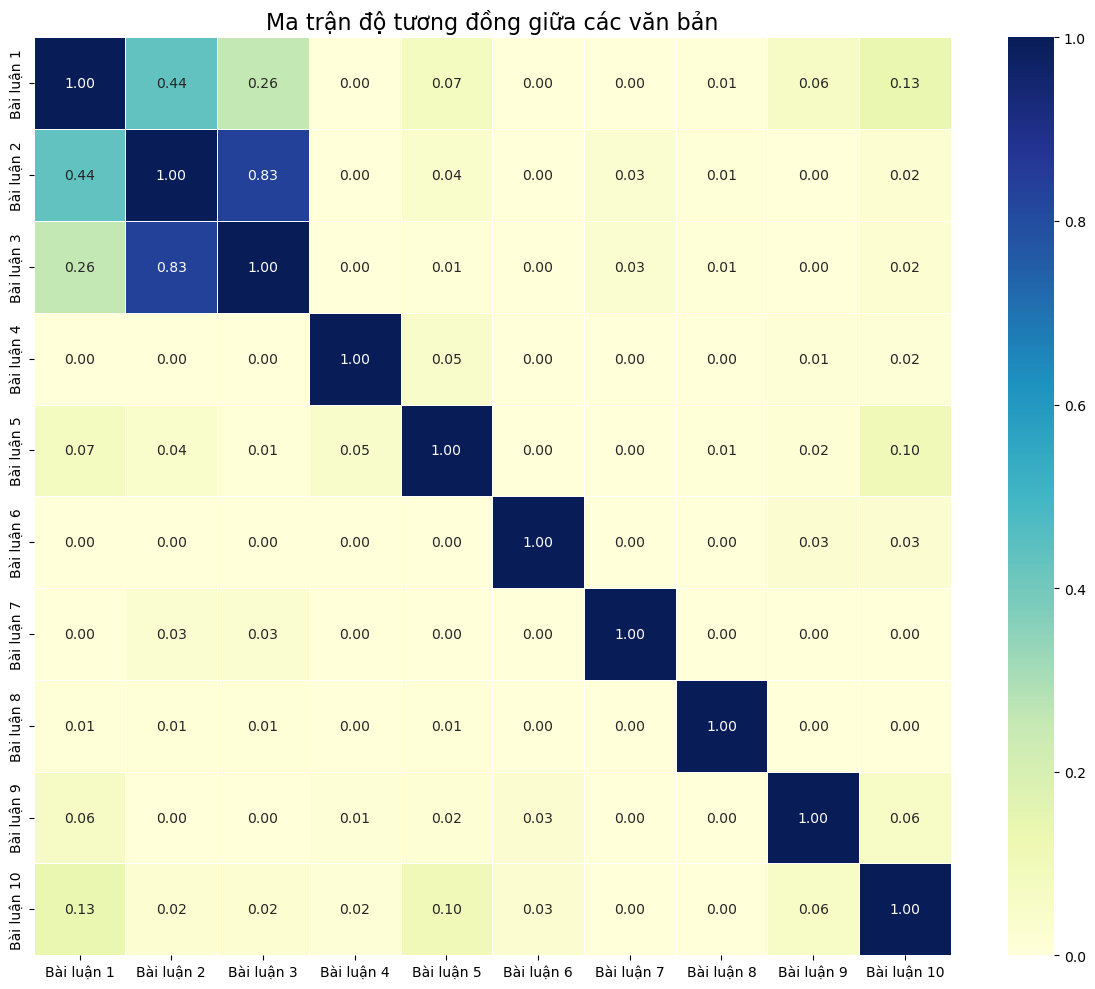

In [13]:
titles = [doc[0] for doc in sample_docs]
documents = [doc[1] for doc in sample_docs]

print(f"Đã tải {len(documents)} văn bản để kiểm tra.")

similarity_matrix, high_similarity_pairs = display_plagiarism_results(documents, titles)
display_high_similarity_analysis(high_similarity_pairs)
save_results_to_database(titles, documents, similarity_matrix)

plt.show()